In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from spafe.features.pncc import pncc

In [2]:
df = pd.read_csv('./coconut-maturity-dataset-wav-luar-kotak.csv')
df

,full_path,file_name,class_name
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature
...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature


In [3]:
def createWaveplot(data, sampleRate, maturity, color):
    plt.figure(figsize=(8,2))
    plt.title(f'Waveplot for {maturity} maturity', size = 15, pad = 20)
    librosa.display.waveshow(data, sr=sampleRate, alpha=0.5, color=color)
    plt.show()

def amplitude_envelope(signal, frame_size: int = 2048, hop_length: int = 512):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []

    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length):
        amplitude_envelope_current_frame = max(signal[i:i+frame_size])
        amplitude_envelope.append(amplitude_envelope_current_frame)

    return np.reshape(np.array(amplitude_envelope), (1, len(amplitude_envelope)))

In [4]:
zcr = []
ae = []
rmse = []
mean = []
variance = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename, sr = 44100)
    mean_result = np.mean(wavSig)
    variiance_result = np.var(wavSig)
    ae_result = amplitude_envelope(wavSig)
    zcr_result = librosa.feature.zero_crossing_rate(wavSig)
    rmse_result = librosa.feature.rms(y=wavSig)
    mean.append(mean_result)
    variance.append(variiance_result)
    ae.append(ae_result[0])
    zcr.append(zcr_result[0])
    rmse.append(rmse_result[0])

In [5]:
df['mean'] = mean
df['variance'] = variance
df['amplitude-envelope'] = ae
df['zero-crossing-rate'] = zcr
df['RMS-energy'] = rmse
df

,full_path,file_name,class_name,mean,variance,amplitude-envelope,zero-crossing-rate,RMS-energy
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,0.000069,0.000408,"[3.0517578e-05, 6.1035156e-05, 6.1035156e-05, ...","[0.09228515625, 0.13427734375, 0.16357421875, ...","[1.7099783e-05, 2.1473561e-05, 2.5625284e-05, ..."
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,0.000026,0.001051,"[6.1035156e-05, 9.1552734e-05, 9.1552734e-05, ...","[0.0654296875, 0.09619140625, 0.130859375, 0.1...","[2.0387228e-05, 2.4518891e-05, 2.8902783e-05, ..."
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,-0.000126,0.001053,"[6.1035156e-05, 6.1035156e-05, 6.1035156e-05, ...","[0.072265625, 0.111328125, 0.15673828125, 0.17...","[2.0331388e-05, 2.4518891e-05, 2.795909e-05, 2..."
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,-0.000061,0.000586,"[9.1552734e-05, 0.00030517578, 0.00039672852, ...","[0.05908203125, 0.0859375, 0.11181640625, 0.10...","[2.7167167e-05, 3.4365374e-05, 4.0640403e-05, ..."
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,-0.000075,0.000980,"[6.1035156e-05, 6.1035156e-05, 6.1035156e-05, ...","[0.07861328125, 0.11181640625, 0.1484375, 0.13...","[2.1736663e-05, 2.6668798e-05, 3.0097453e-05, ..."
...,...,...,...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,-0.000132,0.000650,"[6.1035156e-05, 6.1035156e-05, 0.00012207031, ...","[0.09130859375, 0.1337890625, 0.17919921875, 0...","[1.9787305e-05, 2.3563669e-05, 2.7116903e-05, ..."
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,-0.000131,0.000500,"[3.0517578e-05, 3.0517578e-05, 3.0517578e-05, ...","[0.06640625, 0.11962890625, 0.158203125, 0.152...","[1.9109215e-05, 2.2099743e-05, 2.550076e-05, 2..."
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,-0.000091,0.000763,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,0.000019,0.000815,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


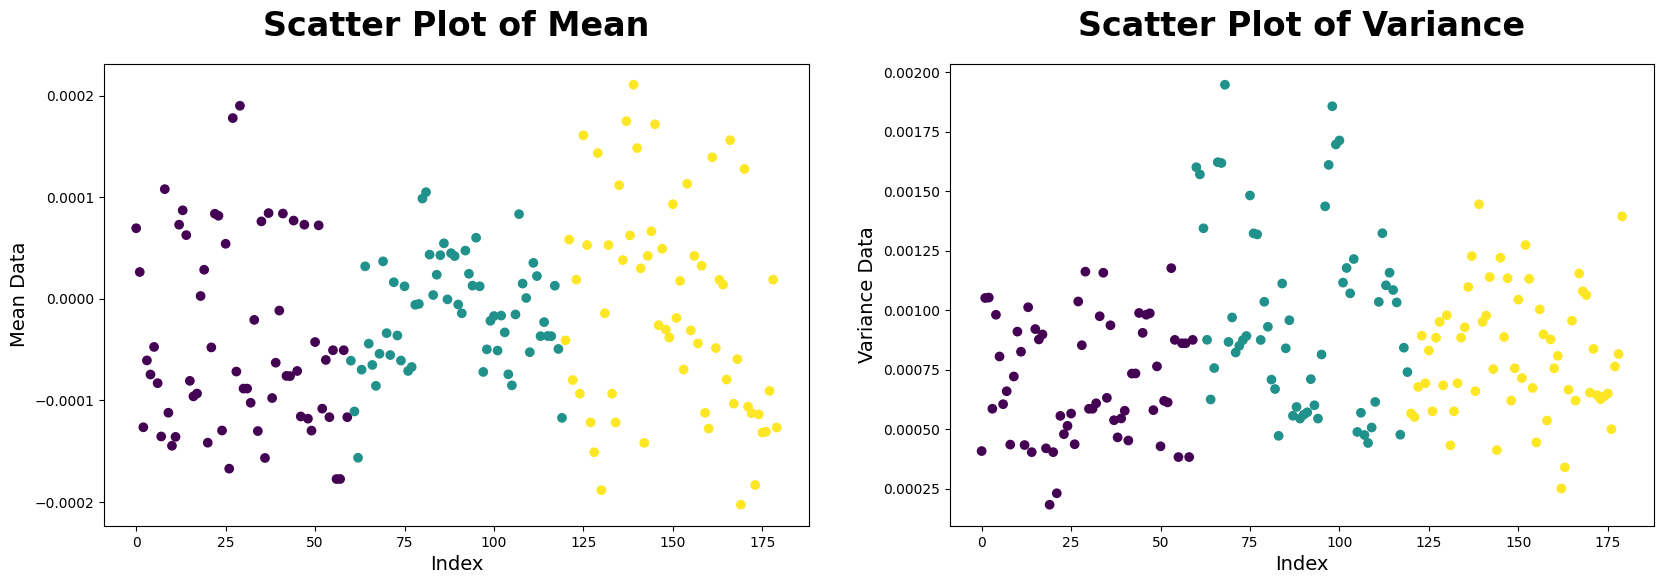

In [6]:
mean_data = df['mean'].values
var_data = df['variance'].values
indices = np.arange(180)
colors = np.repeat(range(3), 60)

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.scatter(indices, mean_data, c=colors)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Mean Data', fontsize=14)
plt.title('Scatter Plot of Mean', fontsize=24, pad=20, fontweight='bold')
plt.subplot(122)
plt.scatter(indices, var_data, c=colors)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Variance Data', fontsize=14)
plt.title('Scatter Plot of Variance', fontsize=24, pad=20, fontweight='bold')
plt.show()

In [7]:
# print(np.stack(df_cut['PNCC-feature'].values).shape)
# print(np.stack(df_cut['MFCC-feature'].values).shape)
print(np.stack(df['amplitude-envelope'].values).shape)
print(np.stack(df['zero-crossing-rate'].values).shape)
print(np.stack(df['RMS-energy'].values).shape)

(180, 87)
(180, 87)
(180, 87)


In [8]:
ae_feature = np.stack(df['amplitude-envelope'].values)
zcr_feature = np.stack(df['zero-crossing-rate'].values)
rmse_feature = np.stack(df['RMS-energy'].values)

X = np.concatenate((ae_feature,
                    zcr_feature,
                    rmse_feature), axis=1)

X.shape

(180, 261)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(180, 261)

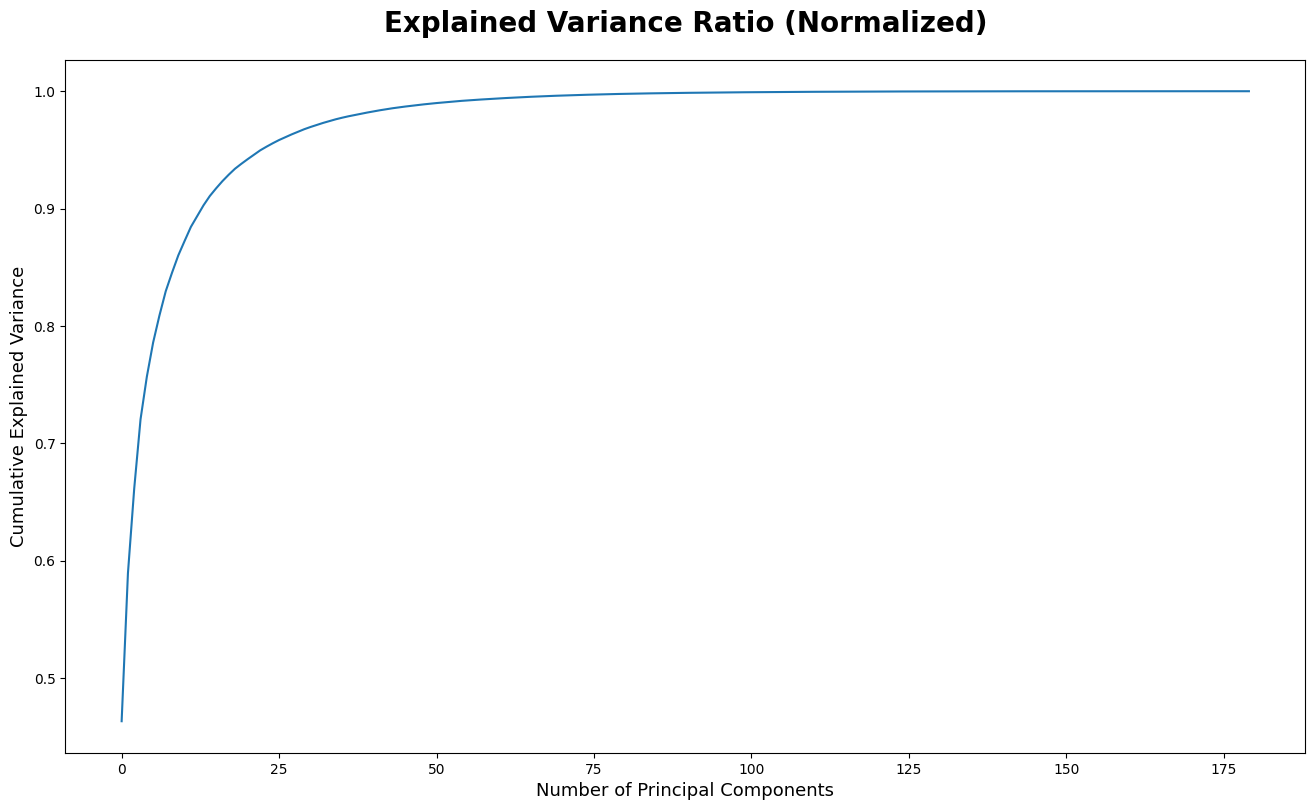

In [10]:
pca = PCA()
pca.fit(X_scaled)
pca_result = pca.transform(X_scaled)

plt.subplots(figsize = (16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Explained Variance Ratio (Normalized)', fontsize=20, pad=20, fontweight='bold')
plt.show()

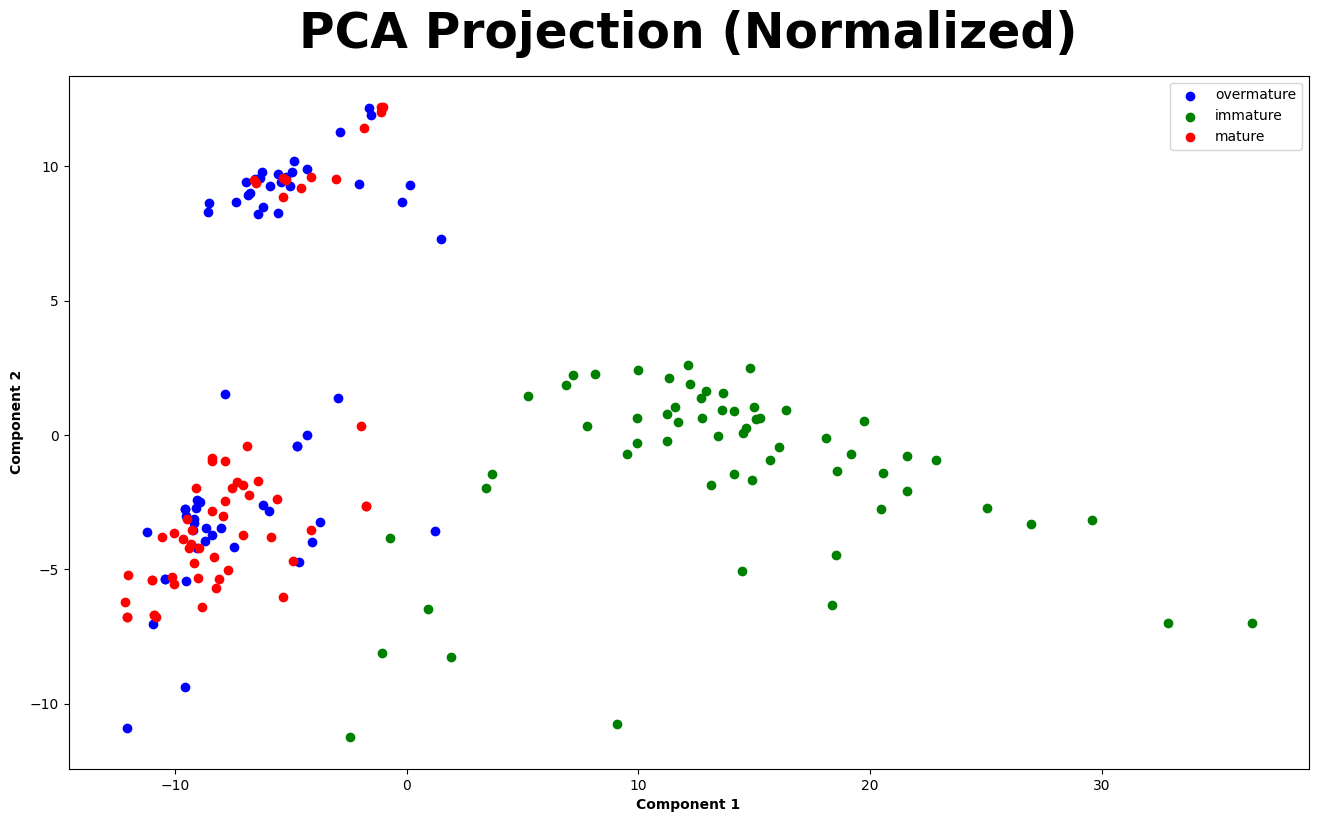

In [11]:
pca = PCA()
pca.fit(X_scaled)
pca_result = pca.transform(X_scaled)

labels = df['class_name'].values.tolist()

# Create a dictionary to map labels to colors for plotting
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], label=label)

plt.title('PCA Projection (Normalized)', fontsize=35, pad=20, fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

# Add a legend
ax.legend()

# Show the plot
plt.show()

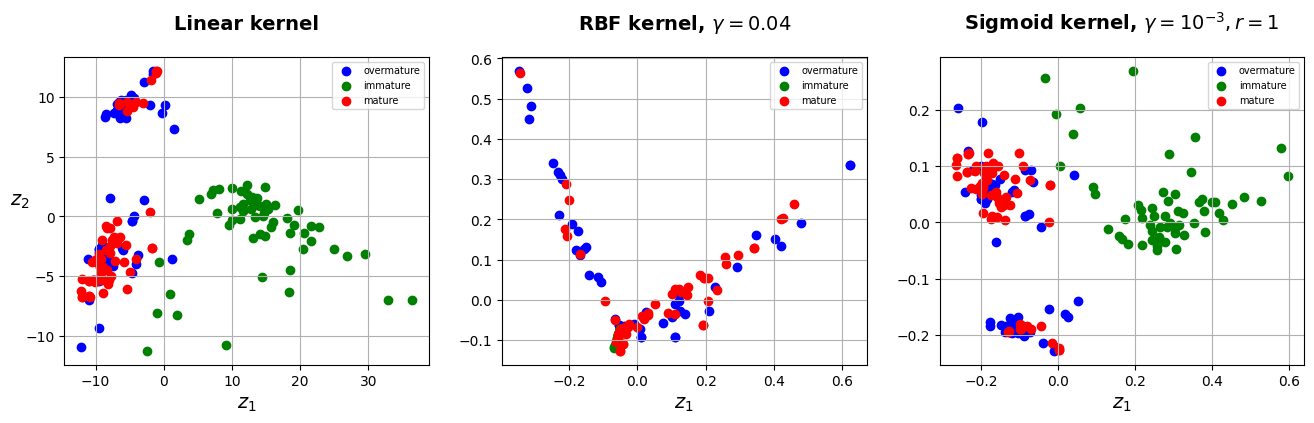

In [12]:
lin_pca = KernelPCA(n_components=25, kernel="linear")
rbf_pca = KernelPCA(n_components=25, kernel="rbf", gamma=0.0433)
sig_pca = KernelPCA(n_components=25, kernel="sigmoid", gamma=0.001)

unique_labels = set(labels)
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

plt.figure(figsize=(16, 4))
for subplot, pca, title in((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    reduced = pca.fit_transform(X_scaled)

    x = reduced[:, 0]
    y = reduced[:, 1]

    plt.subplot(subplot)
    for label in unique_labels:
        indices = np.where(np.array(labels) == label)
        plt.scatter(x[indices], y[indices], c=label_colors[label], label=label)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("$z_1$", fontsize=14)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=14, rotation=0)
    plt.legend(fontsize=7)
    plt.grid()
plt.show()

In [13]:
# Create an instance of OneHotEncoder
labels = df['class_name'].values
one_hot_encoder = OneHotEncoder()

# Fit and transform the labels
encoded_labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

In [14]:
print(f'ukuran data fitur : {encoded_labels.shape}')
print(f'ukuran data label : {X_scaled.shape}')

ukuran data fitur : (180, 3)
ukuran data label : (180, 261)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, encoded_labels, train_size=0.8, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((144, 261), (144, 3), (36, 261), (36, 3))

In [16]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)
print(f"Ukuran data train\t: {x_train.shape}")
print(f"Ukuran data test\t: {x_test.shape}")

Ukuran data train	: (144, 261, 1)
Ukuran data test	: (36, 261, 1)


In [17]:
log_dir = os.path.join('logs_bidirectional')
tb_callback = TensorBoard(log_dir=log_dir)
checkpoint_filepath = 'checkpoint_bidirectional/model_checkpoints_{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=False,
                                      save_weights_only=False,
                                      save_freq=5)

In [18]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,
                             dropout=0.05,
                             recurrent_dropout=0.20),
                             input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer = Adam(1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                        

In [19]:
LSTM_model = model.fit(x_train, y_train, batch_size=12, epochs=50, validation_data=(x_test, y_test), callbacks=[tb_callback, checkpoint_callback])

Epoch 1/50
12/12 [==============================] - 24s 1s/step - loss: 1.0781 - accuracy: 0.5139 - val_loss: 1.0616 - val_accuracy: 0.5833
Epoch 2/50
12/12 [==============================] - 10s 872ms/step - loss: 1.0494 - accuracy: 0.6250 - val_loss: 1.0282 - val_accuracy: 0.6111
Epoch 3/50
12/12 [==============================] - 11s 927ms/step - loss: 1.0082 - accuracy: 0.6458 - val_loss: 0.9801 - val_accuracy: 0.6111
Epoch 4/50
12/12 [==============================] - 11s 969ms/step - loss: 0.9543 - accuracy: 0.6389 - val_loss: 0.9000 - val_accuracy: 0.6111
Epoch 5/50
12/12 [==============================] - 11s 961ms/step - loss: 0.8462 - accuracy: 0.6597 - val_loss: 0.7692 - val_accuracy: 0.6111
Epoch 6/50
12/12 [==============================] - 11s 895ms/step - loss: 0.7219 - accuracy: 0.6667 - val_loss: 0.6324 - val_accuracy: 0.6111
Epoch 7/50
12/12 [==============================] - 11s 932ms/step - loss: 0.6199 - accuracy: 0.6528 - val_loss: 0.5851 - val_accuracy: 0.6111
Ep

In [20]:
modelResults = model.evaluate(x_test, y_test)

2/2 [==============================] - 4s 81ms/step - loss: 0.5005 - accuracy: 0.6389


LOSS		: 50.05%
ACCURACY	: 63.89%


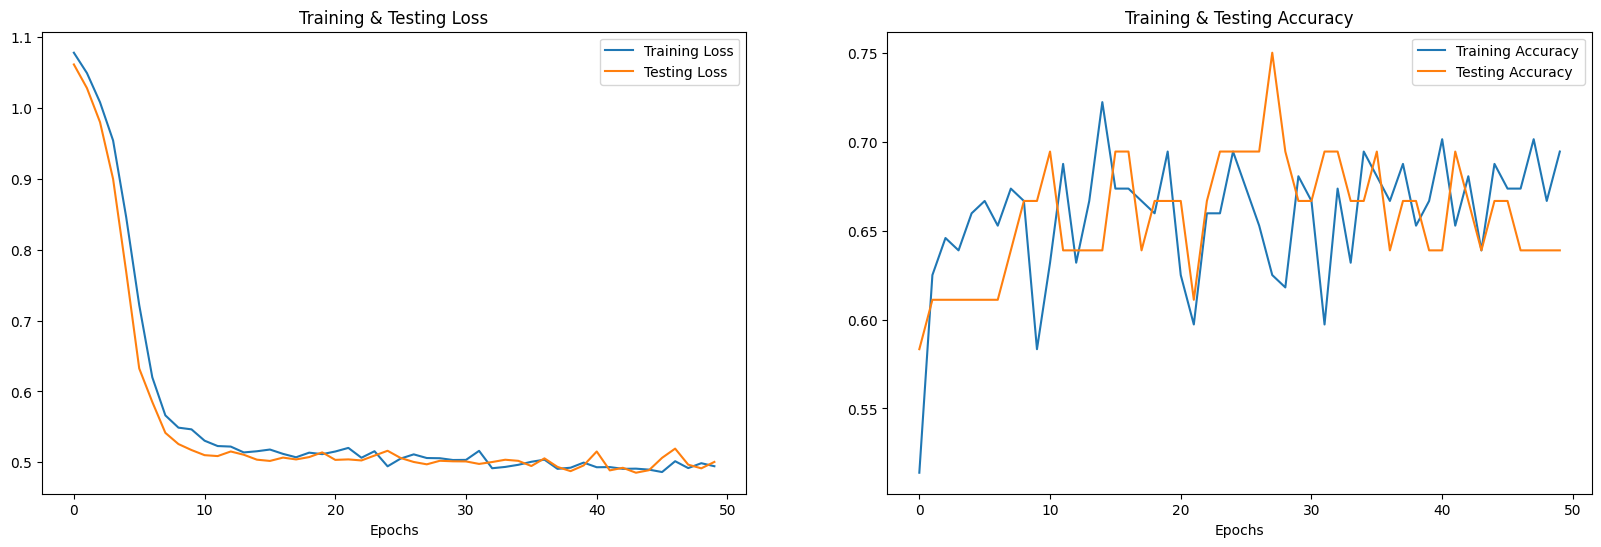

In [23]:
print(f"LOSS\t\t: {round(modelResults[0]*100,2)}%")
print(f"ACCURACY\t: {round(modelResults[1]*100,2)}%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = LSTM_model.history['accuracy']
train_loss = LSTM_model.history['loss']
test_acc = LSTM_model.history['val_accuracy']
test_loss = LSTM_model.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [21]:
pred_test = model.predict(x_test)
y_pred = one_hot_encoder.inverse_transform(pred_test)
y_test = one_hot_encoder.inverse_transform(y_test)
df_predict = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_predict['Predicted Labels'] = y_pred.flatten()
df_predict['Actual Labels'] = y_test.flatten()
df_predict.head(10)

2/2 [==============================] - 2s 107ms/step


,Predicted Labels,Actual Labels
0,mature,overmature
1,immature,immature
2,immature,immature
3,immature,immature
4,immature,immature
5,immature,immature
6,immature,overmature
7,mature,mature
8,mature,mature
9,mature,mature


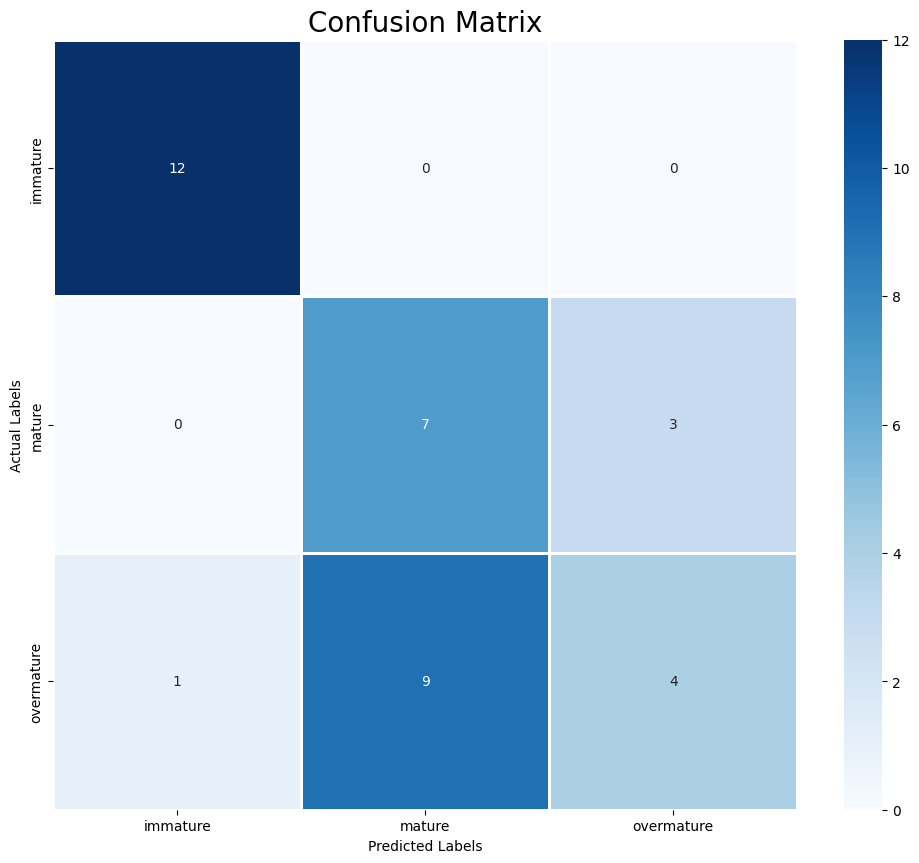

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in one_hot_encoder.categories_] , columns = [i for i in one_hot_encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    immature       0.92      1.00      0.96        12
      mature       0.44      0.70      0.54        10
  overmature       0.57      0.29      0.38        14

    accuracy                           0.64        36
   macro avg       0.64      0.66      0.63        36
weighted avg       0.65      0.64      0.62        36



In [25]:
model.save('LSTM_bidirectional_model')

INFO:tensorflow:Assets written to: LSTM_bidirectional_model\assets


INFO:tensorflow:Assets written to: LSTM_bidirectional_model\assets
